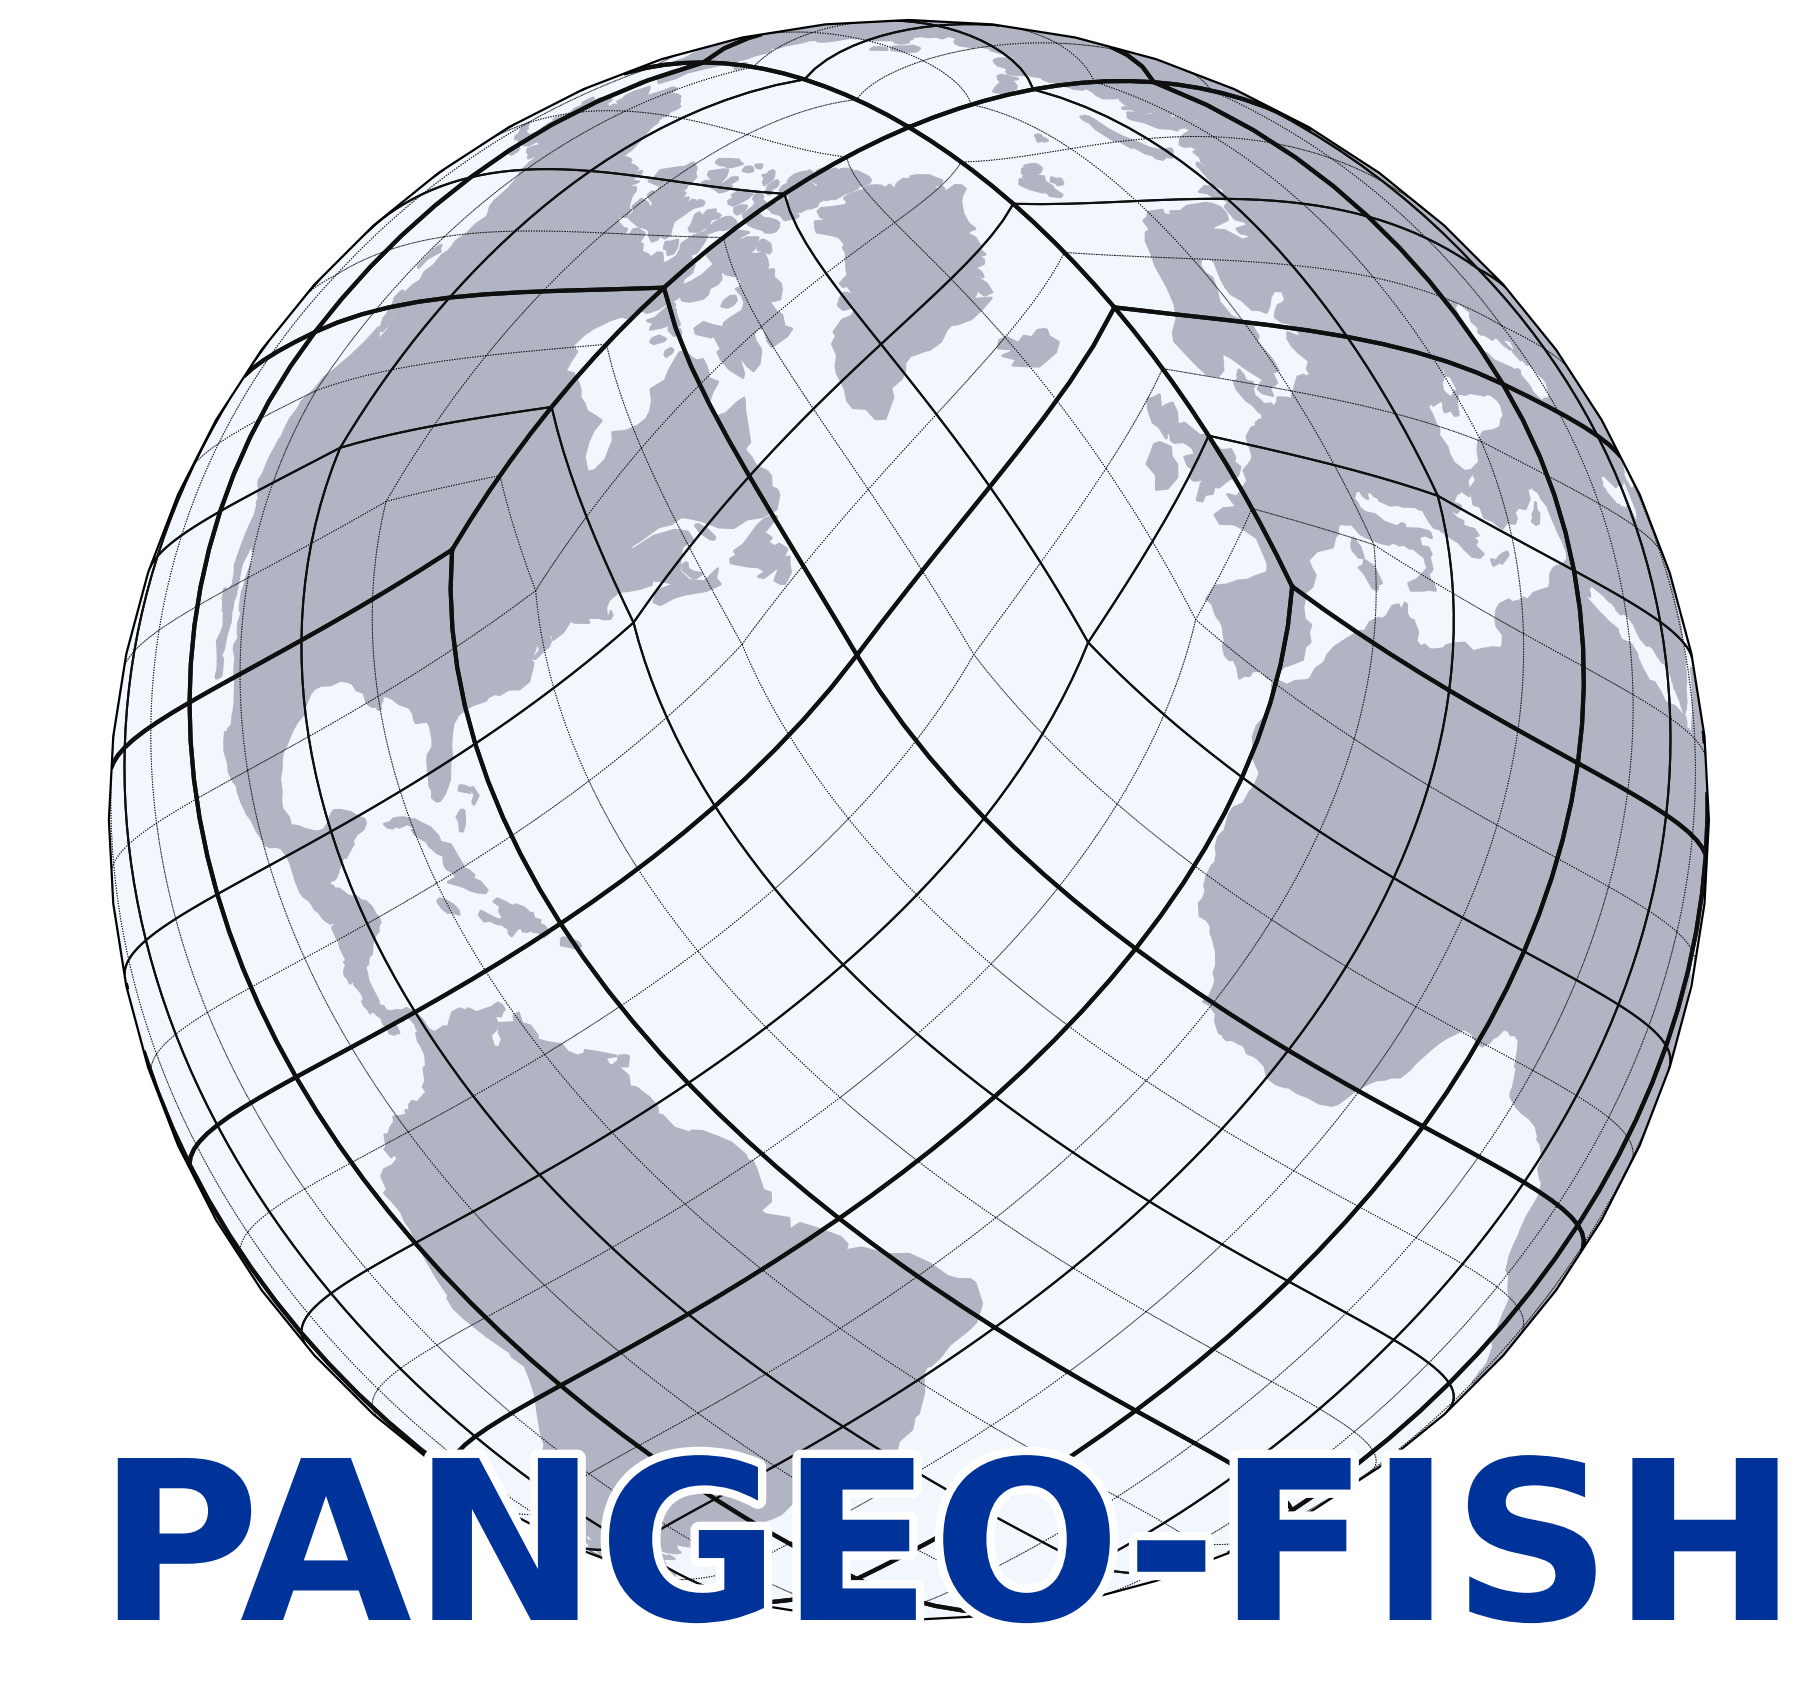

In [8]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import healpy as hp
import numpy as np
import matplotlib.patheffects as path_effects


def plot_healpix_grid(ax, level, color='black', linewidth=0.5, linestyle='-'):
    """Plot HEALPix grid lines for a given level (NSIDE = 2**level)."""
    nside = 2**level
    npix = hp.nside2npix(nside)
    for pix in range(npix):
        boundary = hp.boundaries(nside, pix, step=10)
        lon, lat = hp.vec2ang(boundary.T, lonlat=True)
        lon = np.append(lon, lon[0])
        lat = np.append(lat, lat[0])
        ax.plot(lon, lat, transform=ccrs.Geodetic(),
                color=color, linewidth=linewidth, linestyle=linestyle)


# Create the figure with a transparent background
fig = plt.figure(figsize=(8, 8), dpi=200)
fig.patch.set_alpha(0.0)

# Create orthographic globe projection centered over Europe
projection = ccrs.Orthographic(central_longitude=-40, central_latitude=30)
ax = plt.axes([0, 0, 1, 1], projection=projection)
ax.set_global()
ax.patch.set_alpha(0.0)

# Add land, ocean, and coastlines
#🩶 Medium Grey#A0A0A0
#🌫 Warm Grey#B6B6B6
#🫒 Greyish Olive#8A9A5B
#🌿 Destination Green#6E8B3D

land='lightgray'
land='#A0A0A0'#Medium Grey
land='#B6B6B6'#Warm Grey
land='#8A9A5B' # Greyish Olive
#land='#6E8B3D' #Destination Green
land = '#84BD00'  # Destination Green
#land = '#A6A6A6'  # Mid Grey
#land = '#6E6E6E'  # Dark Grey
#land = '#1C1C1C'  # Charcoal
#land = '#F39200'  # Destination Orange
#land = '#E03C31'  # Destination Red
land = '#D9D9D6'  # Light Grey (neutral tone sea)
#land = '#FFD100'  # Destination Yellow
land = '#F6F9FC'  # Light Grey (neutral tone sea)
land = '#B1B5C3'  # Light Grey (neutral tone sea)

ocean='#99CCFF'
#ocean='lightblue'
ocean = '#00B5E2'  # Destination Cyan
#ocean = '#0066B3'  # Destination Blue
ocean = '#D9D9D6'  # Light Grey (neutral tone sea)
ocean = '#F5F5F5'  # Off White (very soft background)
ocean = '#F2F7FD'  # Off White (very soft background)

text_colour= "#003399"  # ESA blue
text_colour = "#003399"  # ESA Blue (corporate, deep blue)
#text_colour = "#0066B3"  # Destination Blue (primary brand color)
#text_colour = "#1C1C1C"  # Charcoal (almost black, very readable)
#text_colour = "#6E6E6E"  # Dark Grey (subtle but strong contrast)
#text_colour = "#A6A6A6"  # Mid Grey (for soft neutral contrast)
#text_colour = "#00B5E2"  # Destination Cyan (fresh and energetic)
#text_colour = "#84BD00"  # Destination Green (natural tone for Earth themes)
#text_colour = "#F39200"  # Destination Orange (warm and attention-grabbing)
#text_colour = "#E03C31"  # Destination Red (strong alert-style emphasis)
#text_colour = "#2F3842"  #DestinE
#text_colour2="#100F0F"

ax.add_feature(cfeature.LAND, facecolor=land)
ax.add_feature(cfeature.OCEAN, facecolor=ocean)
ax.coastlines(resolution='110m', color=land)

# Plot HEALPix grids at levels 1 (thick), 2 (medium), and 3 (thin dotted)
plot_healpix_grid(ax, level=1, color=text_colour2, linewidth=1.5, linestyle='-')
plot_healpix_grid(ax, level=2, color=text_colour2, linewidth=0.75, linestyle='-')
plot_healpix_grid(ax, level=3, color=text_colour2,  linewidth=0.35, linestyle=':')

# Add centered text label inside the globe with white outline
text = plt.text(0.5, 0, " PANGEO-FISH",
                fontsize=80,
                color=text_colour, 
                ha='center',
                weight='bold',
                transform=fig.transFigure)

text.set_path_effects([
    path_effects.Stroke(linewidth=6, foreground='white'),
    path_effects.Normal()
])

# Save the result with transparent background and padding to avoid clipping
plt.savefig("logo.png", transparent=True, bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()

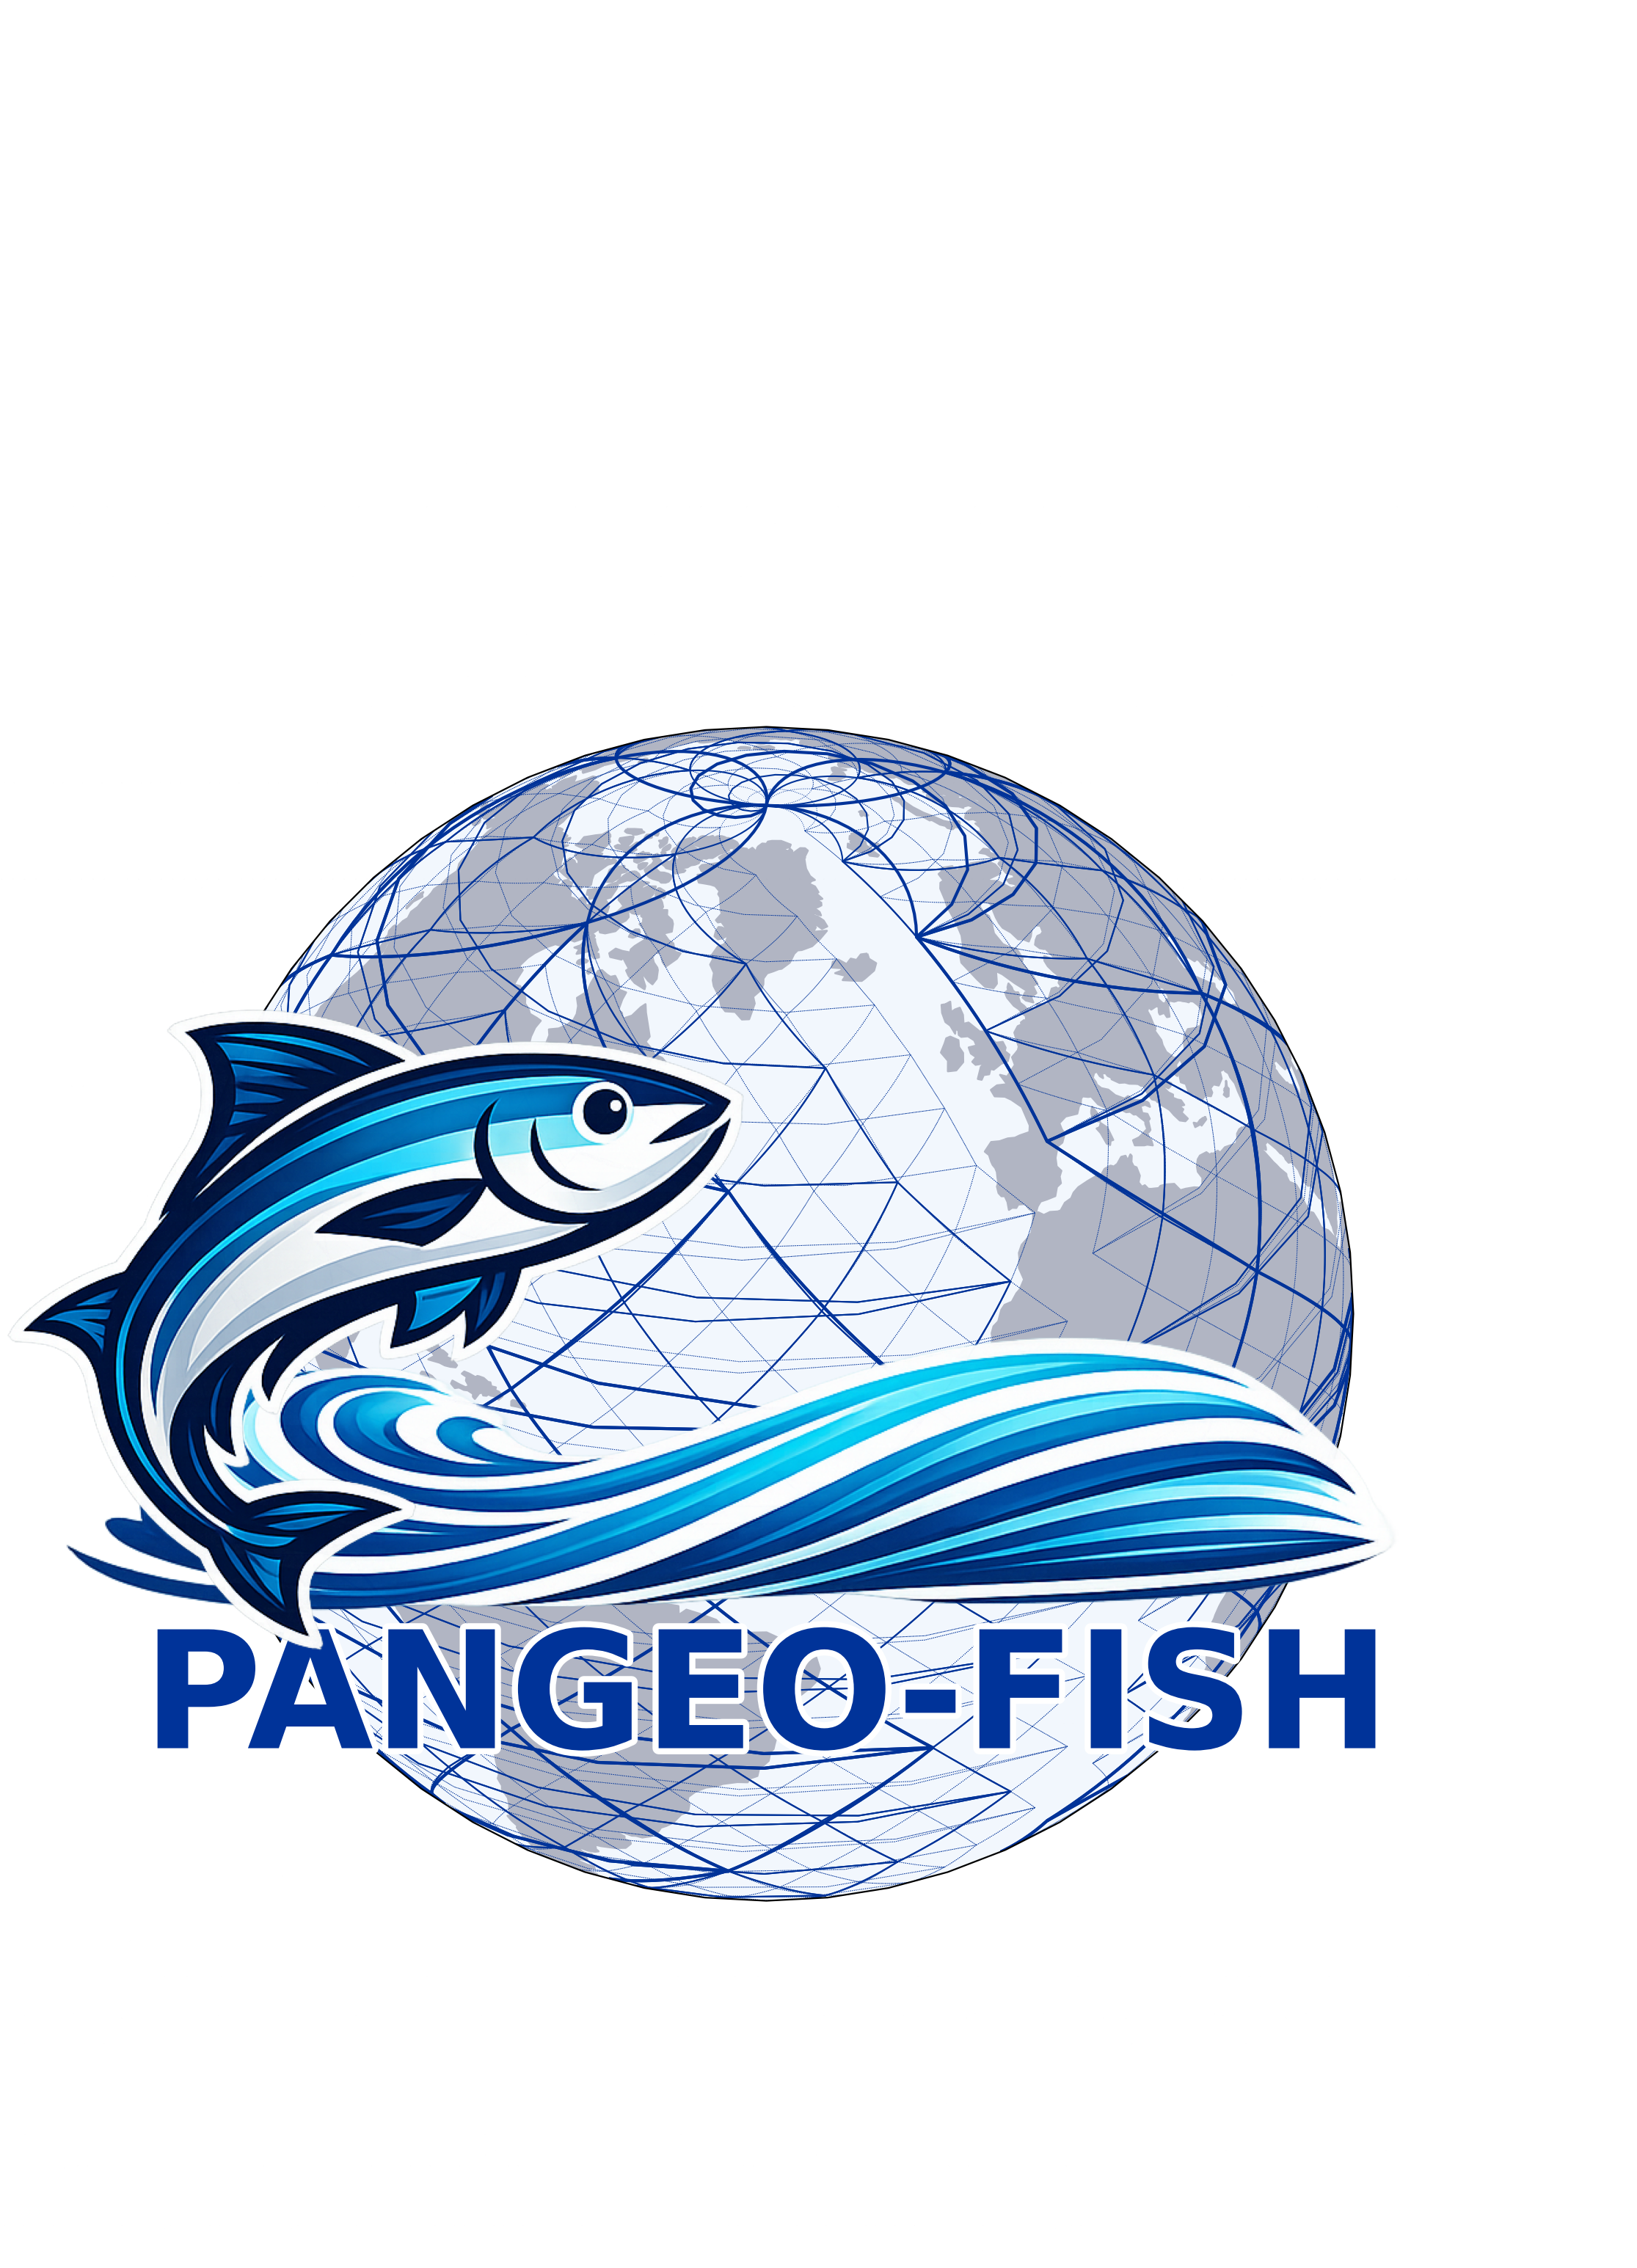

In [26]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import healpy as hp
import numpy as np
import matplotlib.patheffects as path_effects
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


def densify_edge(lon1, lat1, lon2, lat2, npts=20):
    """Interpolate npts points between two lon/lat vertices."""
    lons = np.linspace(lon1, lon2, npts)
    lats = np.linspace(lat1, lat2, npts)
    return lons, lats


def plot_healpix_grid(ax, level, color='black',
                      linewidth=0.5, linestyle='-',
                      ellipsoid="WGS84",
                      edge_points=20):
    """
    Plot HEALPix grid lines using healpix-geo with densified edges.
    edge_points ~ equivalent to hp.boundaries(step=...)
    """
    depth = int(level)
    npix = 12 * (4 ** depth)

    ipix = np.arange(npix, dtype=np.uint64)
    lon_v, lat_v = vertices(ipix, depth=depth, ellipsoid=ellipsoid)

    for i in range(npix):
        lon = lon_v[i]
        lat = lat_v[i]

        # 4 edges of the quad
        lon_edges = []
        lat_edges = []

        for j in range(4):
            lon1, lat1 = lon[j], lat[j]
            lon2, lat2 = lon[(j + 1) % 4], lat[(j + 1) % 4]

            lons_e, lats_e = densify_edge(lon1, lat1, lon2, lat2, npts=edge_points)

            lon_edges.append(lons_e)
            lat_edges.append(lats_e)

        lon_all = np.concatenate(lon_edges)
        lat_all = np.concatenate(lat_edges)

        ax.plot(
            lon_all,
            lat_all,
            transform=ccrs.Geodetic(),
            color=color,
            linewidth=linewidth,
            linestyle=linestyle
        )


def add_png(fig, png_path, xy=(0.5, 0.5), zoom=0.2, zorder=50):
    """
    Place a PNG on a figure at position xy in figure-fraction coordinates (0..1).
    Keeps transparency.
    """
    img = mpimg.imread(png_path)  # RGBA if PNG has alpha
    oi = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(
        oi, xy,
        xycoords='figure fraction',
        frameon=False,
        box_alignment=(0.5, 0.5),
        zorder=zorder
    )
    fig.add_artist(ab)
    return ab


# -----------------------
# Figure (transparent bg)
# -----------------------
fig = plt.figure(figsize=(8, 8), dpi=200)
fig.patch.set_alpha(0.0)

# Globe projection
projection = ccrs.Orthographic(central_longitude=-40, central_latitude=30)
ax = plt.axes([0, 0, 1, 1], projection=projection)
ax.set_global()
ax.patch.set_alpha(0.0)

# Colors
land = '#B1B5C3'
ocean = '#F2F7FD'
text_colour = "#003399"  # ESA blue
text_colour2 = text_colour  # <-- FIX: you used text_colour2 but never defined it

# Background features
ax.add_feature(cfeature.LAND, facecolor=land)
ax.add_feature(cfeature.OCEAN, facecolor=ocean)
ax.coastlines(resolution='110m', color=land)

# HEALPix grids
plot_healpix_grid(ax, level=1, color=text_colour2, linewidth=1.5, linestyle='-')
plot_healpix_grid(ax, level=2, color=text_colour2, linewidth=0.75, linestyle='-')
plot_healpix_grid(ax, level=3, color=text_colour2, linewidth=0.35, linestyle=':')

# -----------------------
# Overlay your PNG assets
# -----------------------
# TUNE THESE:
# - xy sets the placement (0..1 in figure)
# - zoom controls size (try 0.10–0.60 depending on your PNG resolution)
# - zorder controls which is on top

# wave behind fish
add_png(fig, "wave4.png",    xy=(0.60, 0.64), zoom=0.7, zorder=60)
add_png(fig, "fishonly.png", xy=(0.4, 0.8), zoom=0.6, zorder=70)

# -----------------------
# Text
# -----------------------
text = plt.text(
    0.5, 0.13, "PANGEO-FISH",
    fontsize=80,
    color=text_colour,
    ha='center',
    weight='bold',
    transform=fig.transFigure,
    zorder=80
)

text.set_path_effects([
    path_effects.Stroke(linewidth=6, foreground='white'),
    path_effects.Normal()
])

# Save transparent

plt.savefig("logo.png", transparent=True, bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()

In [24]:
from PIL import Image
from pathlib import Path

# Input file
input_path = Path("logo.png")
img = Image.open(input_path).convert("RGBA")

# Resize (max dimension)
target = 400  # change to 256, 300, 320, 400 depending on your need
w, h = img.size
scale = target / max(w, h)
new_size = (round(w * scale), round(h * scale))

img_small = img.resize(new_size, Image.Resampling.LANCZOS)

# --- High-quality optimized PNG ---
img_small.save(
    "pangeo-fish-logo_small.png",
    format="PNG",
    optimize=True,
    compress_level=9  # max compression
)

# --- Smaller palette PNG (optional) ---
# Better method for RGBA
img_q = img_small.quantize(
    colors=256,
    method=Image.Quantize.FASTOCTREE,
    dither=Image.Dither.FLOYDSTEINBERG
)

img_q.save(
    "pangeo-fish-logo_small_quant.png",
    format="PNG",
    optimize=True,
    compress_level=9
)

print("Done.")

Done.


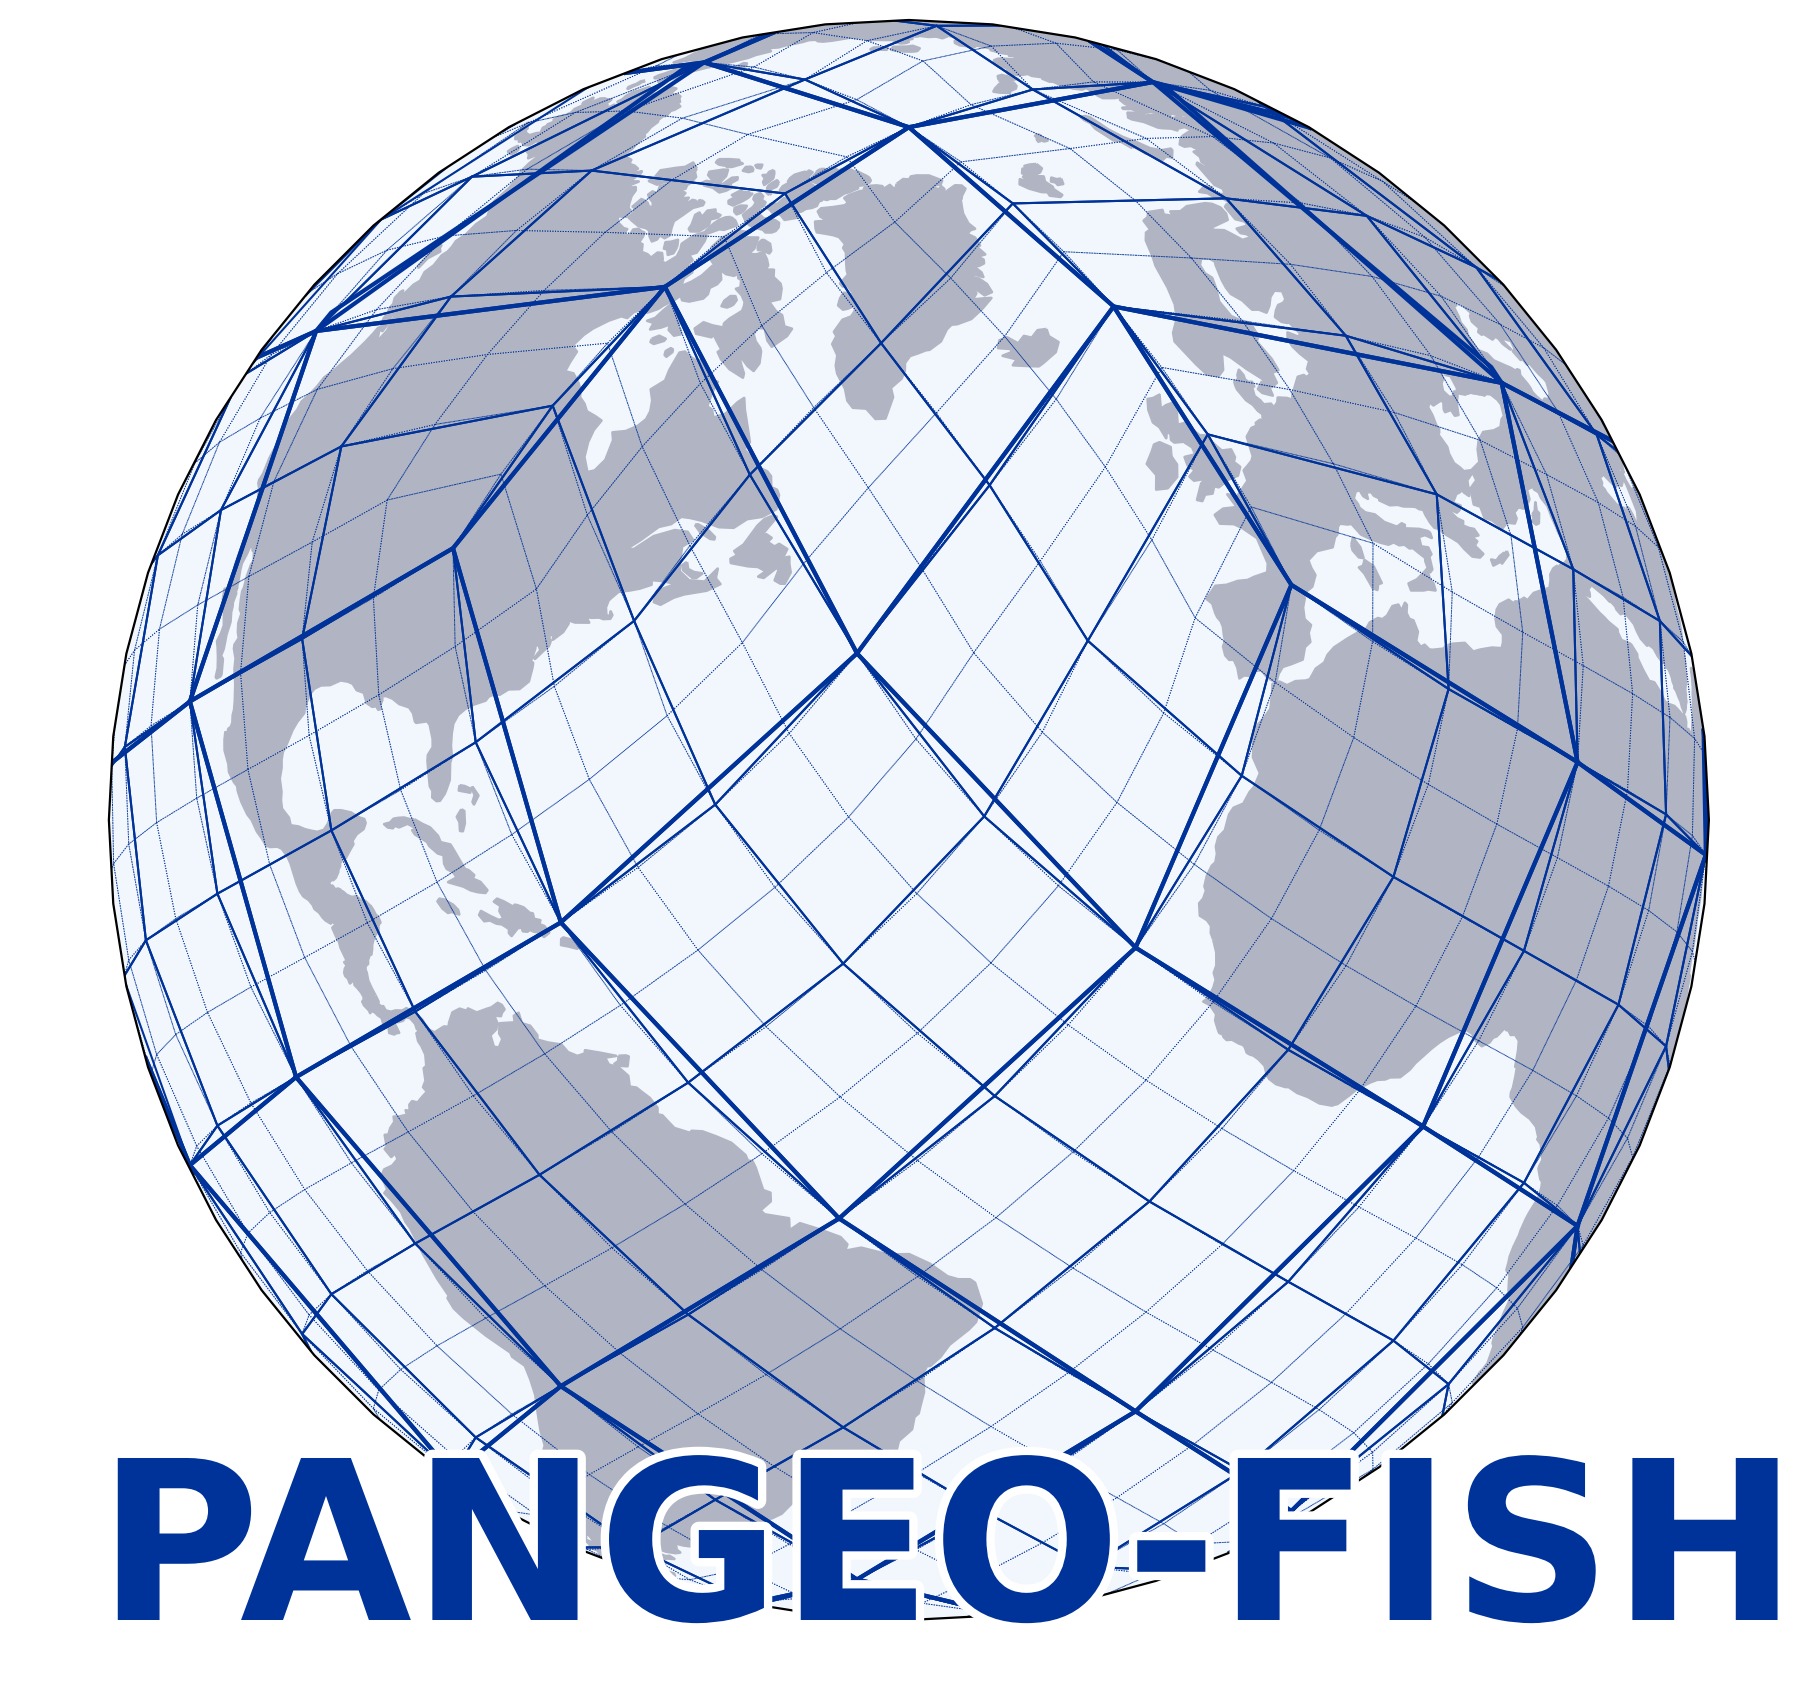

In [25]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.patheffects as path_effects

from healpix_geo.nested import vertices  # <- healpix-geo


def plot_healpix_grid(ax, level, color='black', linewidth=0.5, linestyle='-', ellipsoid="WGS84"):
    """
    Plot HEALPix grid lines for a given level using healpix-geo (nested scheme).

    In healpix-geo, the resolution parameter is 'depth' where:
      depth=0 -> 12 base cells
      depth=level here, matching the usual HEALPix hierarchy (nside = 2**depth).
    """
    depth = int(level)
    npix = 12 * (4 ** depth)  # same as 12 * nside^2, with nside=2**depth

    ipix = np.arange(npix, dtype=np.uint64)

    # lon_v, lat_v are shape (N, 4): the 4 vertices of each cell
    lon_v, lat_v = vertices(ipix, depth=depth, ellipsoid=ellipsoid)  # WGS84 recommended  [oai_citation:1‡healpix-geo.readthedocs.io](https://healpix-geo.readthedocs.io/en/latest/tutorials/ellipsoid_basics.html)

    # Plot each cell outline
    for i in range(npix):
        lon = lon_v[i]
        lat = lat_v[i]
        # close polygon
        lon = np.append(lon, lon[0])
        lat = np.append(lat, lat[0])

        ax.plot(
            lon, lat,
            transform=ccrs.Geodetic(),
            color=color,
            linewidth=linewidth,
            linestyle=linestyle
        )


# Create the figure with a transparent background
fig = plt.figure(figsize=(8, 8), dpi=200)
fig.patch.set_alpha(0.0)

# Create orthographic globe projection centered over Europe
projection = ccrs.Orthographic(central_longitude=-40, central_latitude=30)
ax = plt.axes([0, 0, 1, 1], projection=projection)
ax.set_global()
ax.patch.set_alpha(0.0)

# Colors
land = '#B1B5C3'
ocean = '#F2F7FD'

text_colour = "#003399"      # ESA blue
text_colour2 = text_colour   # <- your code referenced text_colour2, so define it

# Add land, ocean, and coastlines
ax.add_feature(cfeature.LAND, facecolor=land)
ax.add_feature(cfeature.OCEAN, facecolor=ocean)
ax.coastlines(resolution='110m', color=land)

# Plot HEALPix grids at levels 1 (thick), 2 (medium), and 3 (thin dotted)
# Using healpix-geo on WGS84 ellipsoid
plot_healpix_grid(ax, level=1, color=text_colour2, linewidth=1.5, linestyle='-', ellipsoid="WGS84")
plot_healpix_grid(ax, level=2, color=text_colour2, linewidth=0.75, linestyle='-', ellipsoid="WGS84")
plot_healpix_grid(ax, level=3, color=text_colour2, linewidth=0.35, linestyle=':', ellipsoid="WGS84")

# Add centered text label inside the globe with white outline
text = plt.text(
    0.5, 0, " PANGEO-FISH",
    fontsize=80,
    color=text_colour,
    ha='center',
    weight='bold',
    transform=fig.transFigure
)

text.set_path_effects([
    path_effects.Stroke(linewidth=6, foreground='white'),
    path_effects.Normal()
])

# Save the result with transparent background and padding to avoid clipping
plt.savefig("logo.png", transparent=True, bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()

In [32]:
y=range(2001, 2024)
#y= ['All']

In [33]:
for year in y:
    print(year)


2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
